In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!pip install --upgrade requests
!pip install scipy==1.1.0
!pip install pillow

from scipy import misc
import time
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import tarfile
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

from selenium import webdriver
from selenium.webdriver.common.by import By
import plotly.graph_objects as go

In [2]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',options=options)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/#2021-2022 HK1/PhanTichTrucQuanDuLieu/Playground/Landslidew/GLC_cname_datetime_processed.csv')
df["geolocation"] = list(zip(df["latitude"],df["longitude"]))

In [4]:
def get_nsew(lat_long,offset_):
  '''
  offset_ = 95 <=> 400 km vuông xung quanh điểm (lat,long)
  '''
  latitude, longitude = lat_long
  offset = offset_ / 1000.0;
  latMax = latitude + offset
  latMin = latitude - offset

  lngOffset = offset * math.cos(latitude * math.pi / 180.0)
  lngMax = longitude + lngOffset
  lngMin = longitude - lngOffset
  return latMax, latMin, lngMax,lngMin#latMax+0.05, latMin-0.05, lngMax+0.05,lngMin-0.05

In [5]:
def get_DEM_tif(lat_long,offset_):

  maxy,miny,maxx,minx = get_nsew(lat_long,offset_)
  print('Achieving data ...',end=' ')

  wd = webdriver.Chrome('chromedriver',options=options)
  wd.get("https://portal.opentopography.org/raster?opentopoID=OTSRTM.122019.4326.1")
  wd.find_element(By.XPATH,"//input[@type='checkbox' and @id='select_coordinates']").click()
  wd.find_element(By.XPATH,"//input[@id='minX']").send_keys(str(minx));
  wd.find_element(By.XPATH,"//input[@id='minY']").send_keys(str(miny));
  wd.find_element(By.XPATH,"//input[@id='maxX']").send_keys(str(maxx));
  wd.find_element(By.XPATH,"//input[@id='maxY']").send_keys(str(maxy));
  wd.find_element(By.XPATH,"//a[@class='btn btn-primary']").click()
  wd.find_element(By.XPATH,"//input[@id='email']").send_keys(str('henrythai63@gmail.com'));
  wd.find_element(By.XPATH,"//input[@id='submitBtn']").click()

  print('Done')
  print('Processing (21s) ...',end=' ')
  time.sleep(25)
  wd.get(wd.current_url)
  wd.find_element(By.XPATH,"//a[@download='rasters_SRTM15Plus.tar.gz']").click()

  print('Done')
  print(time.sleep(2))

  file = tarfile.open('/content/rasters_SRTM15Plus.tar.gz')
  file.extractall('/content/')
  file.close()

  dem = misc.imread('/content/output_SRTM15Plus.tif')
  return dem

In [12]:
def plot_3dmap(dem):
  fig = go.Figure(data=[go.Surface(z= dem)])
  
  fig.update_layout(title='3D Elevation Map', autosize=False,
                    width=800, height=800,
                    margin=dict(l=65, r=50, b=65, t=90))
  fig.show()

In [8]:
df.sample(3)

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,landslide_trigger,landslide_size,landslide_setting,fatality_count,injury_count,storm_name,photo_link,notes,event_import_source,event_import_id,country_name,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude,geolocation
3653,NewsHub,http://www.3news.co.nz/Haast-landslide-affects...,5490,2013-09-10 18:30:00,NaN,"Diana Falls, State Highway 6, Mount Aspiring N...",Wanaka tourism operators are counting the cost...,"Diana Falls, State Highway 6, Mount Aspiring N...",1km,landslide,downpour,medium,above_road,2.0,NaN,NaN,NaN,NaN,glc,5490.0,New Zealand,NZ,Otago,4428.0,Wanaka,73.65023,10/22/2016 03:03:00 PM,2017-11-20 15:17:00,2018-02-15 15:51:00,169.380800,-44.058200,"(-44.0582, 169.3808)"
8038,GMA News,http://webcache.googleusercontent.com/search?q...,7242,2015-07-15 09:00:00,NaN,"Santa, Ilocos Sur",Dozens of passengers were stranded early Frida...,"Santa, Ilocos Sur",5km,landslide,continuous_rain,small,above_road,0.0,0.0,NaN,NaN,NaN,glc,7242.0,Philippines,PH,Ilocos,2283.0,Santa,0.16401,07/20/2015 07:08:00 PM,2017-11-20 15:17:00,2018-02-15 15:51:00,120.435900,17.487000,"(17.487000000000002, 120.4359)"
10763,News Hub,http://www.newshub.co.nz/home/new-zealand/2016...,11086,2016-11-11 15:00:00,NaN,Landslide on Highway 35 west of Motu Bridge,Authorities reopened State Highway 35 in the e...,"Highway 35, New Zealand",5km,rock_fall,rain,small,above_road,0.0,0.0,NaN,NaN,NaN,NaN,NaN,New Zealand,NaN,NaN,NaN,NaN,NaN,07/12/2017 02:00:00 PM,2017-12-19 20:40:00,2018-02-15 15:51:00,177.595887,-37.839925,"(-37.839925, 177.595887)"


In [9]:
dem = get_DEM_tif((34.4406, -97.128),100)
plot_3dmap(dem)

Achieving data ... Done
Processing (21s) ... Done
None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:

    `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.



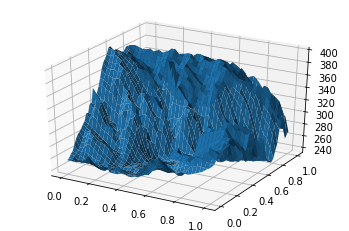

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

ny, nx = dem.shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d= ax.plot_surface(xv,yv,dem)
plt.show()